In [1]:
# To read compressed dicom files:

'''Online'''
#! pip install python-gdcm
#! pip install pylibjpeg pylibjpeg-libjpeg pydicom

'''Offline (need to add dataset --> for-pydicom)'''
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Data



In [3]:
# Load metadata
train_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

# Show first few entries
train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


> **train.csv** - contains metadata for train_images.
> * StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
> * patient_overall - The patient level outcome, i.e. if any of the vertebrae are fractured.
> * C[1-7] - Whether the given vertebrae is fractured.

In [4]:
train_bbox.head(3)

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135


> **train_bounding_boxes.csv** - contains bounding boxes of where fractures occured for a subset of the training set.
> * StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
> * x - x-coordinate of bounding box bottom left corner
> * y - y-coordinate of bounding box bottom left corner
> * width - width of bounding box
> * height - height of bounding box
> * slice_number - slice number of scan

Note: we only have bounding boxes for a [subset](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/343105) of the training set. We'll explore the exact proportion later on.

In [5]:
test_df.head(3)

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


> **test.csv** - contains metadata for test_images.
> * row_id - The row ID. This will match the same column in the sample submission file.
> * StudyInstanceUID - The study ID.
> * prediction_type - Which one of the eight target columns needs a prediction in this row.

Note: The full test set will be **populated at inference time**.

In [6]:
ss.head()

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


> **sample_submission.csv** - A valid sample submission.
> * row_id - The row ID. See the test.csv for what prediction needs to be filed in that row.
> * fracture - The target column.

# 3. EDA


* The overall target is roughly **balanced** (52/48 split). 
* **C7** has the **highest proportion of fractures** (19%) whereas **C3** has the **lowest** (4%). 
* Several patients have **more than one** fracture.
* If **multiple fractures** occur on a single patient, they tend to occur in vertebrae **close together**, e.g. C4 & C5 as opposed to C1 & C7.

(0.0, 2800.0)

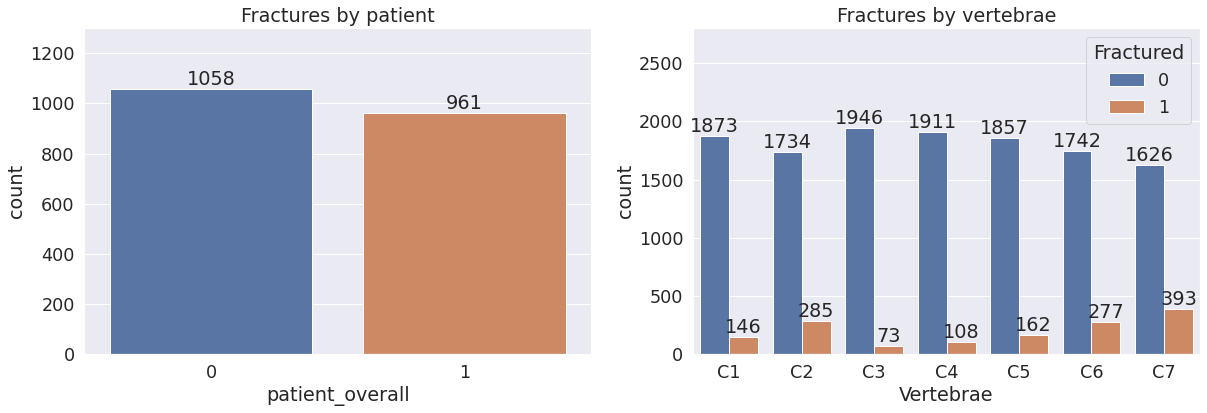

In [7]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

(0.0, 1300.0)

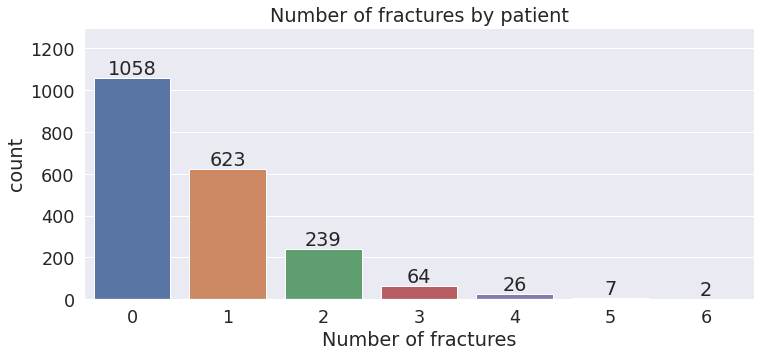

In [8]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

Text(0.5, 1.0, 'Correlations')

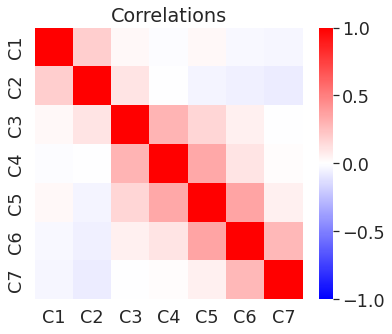

In [9]:
# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')



The cases in the dataset have **unique id's** like '1.2.826.0.1.3680043.6200'. It turns out only the **number after the last full stop** is important. 

In [10]:
# Example
train_df['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.6200'

In [11]:
# Find unique numbers in study id's
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


# 4. Train images



A **.dcm** file follows the **Digital Imaging and Communications in Medicine** (DICOM) format. It is the standard format used for storing **medical images** and **related metadata**. It dates back to 1983, although it has been revised many times. 

We can use the [pydicom library](https://pydicom.github.io/) to open and explore these files.

In [12]:
ex_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/101.dcm"
dcm_example = pydicom.dcmread(ex_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10001.1.101
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10001.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '175846.512627'
(0010, 0010) Patient's Name                      PN: '10001'
(0010, 0020) Patient ID                          LO: '10001'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

The **image data** is stored in an array under **'Pixel Data'**. Everything else is **metadata**.
* The **'Rows'** and **'Columns'** values tell us the **image size**.
* The **'Pixel Spacing'** and **'Slice Thickness'** tell us the **pixel size** and **thickness**.
* The **'Window Center'** and **'Window Width'** give information about the **brightness** and **contrast** of the image respectively.
* The **'Rescale Intercept'** and **'Rescale Slope'** determine the range of pixel values. ([ref](https://stackoverflow.com/questions/10193971/rescale-slope-and-rescale-intercept)).
* **'ImagePositionPatient'** tells us the x, y, and z coordinates of the top left corner of each image in mm
* **InstanceNumber** is the slice number.



Let's look at the what the **image data** from the dcm files look like.

In [ ]:
# Adapted from https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
patient_id = '1.2.826.0.1.3680043.12281'
dcm_paths = glob(f"{base_path}/train_images/{patient_id}/*")
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
dcm_paths.sort(key=natural_keys)

# Get images
files = [pydicom.dcmread(path) for path in dcm_paths]
images = [apply_voi_lut(file.pixel_array, file) for file in files]

# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

start = 110
for i in range(start,start+18):
    img = images[i]
    file = files[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

This is great, but at the moment we don't know which **vertebrae** is being shown in each image. One way to work this out is by using the **segmentations**.

# 5. Segmentations


A **.nii** file follows the **Neuroimaging Informatics Technology Initiative** (NIfTI) format. Compared to the DICOM, NIfTI is **simpler** and **easier** to support. 

To open .nii files we can use the [nibabel library](https://nipy.org/nibabel/gettingstarted.html).

In [14]:
ex_path2 = f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{patient_id}.nii"
nii_example = nib.load(ex_path2)

# Convert to numpy array
seg = nii_example.get_fdata()
seg.shape

(512, 512, 331)

Each nifti file contains segmentations for **all slices** in a scan. However, we need to be careful about the **orientation** of the segmentations.

> Please be aware that the NIFTI files consist of segmentation in the sagittal plane, while the DICOM files are in the axial plane.

The correct way to deal with this is explained in this [discussion post](https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612). We need to use the following line:

In [15]:
# Align orientation with images
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

(331, 512, 512)

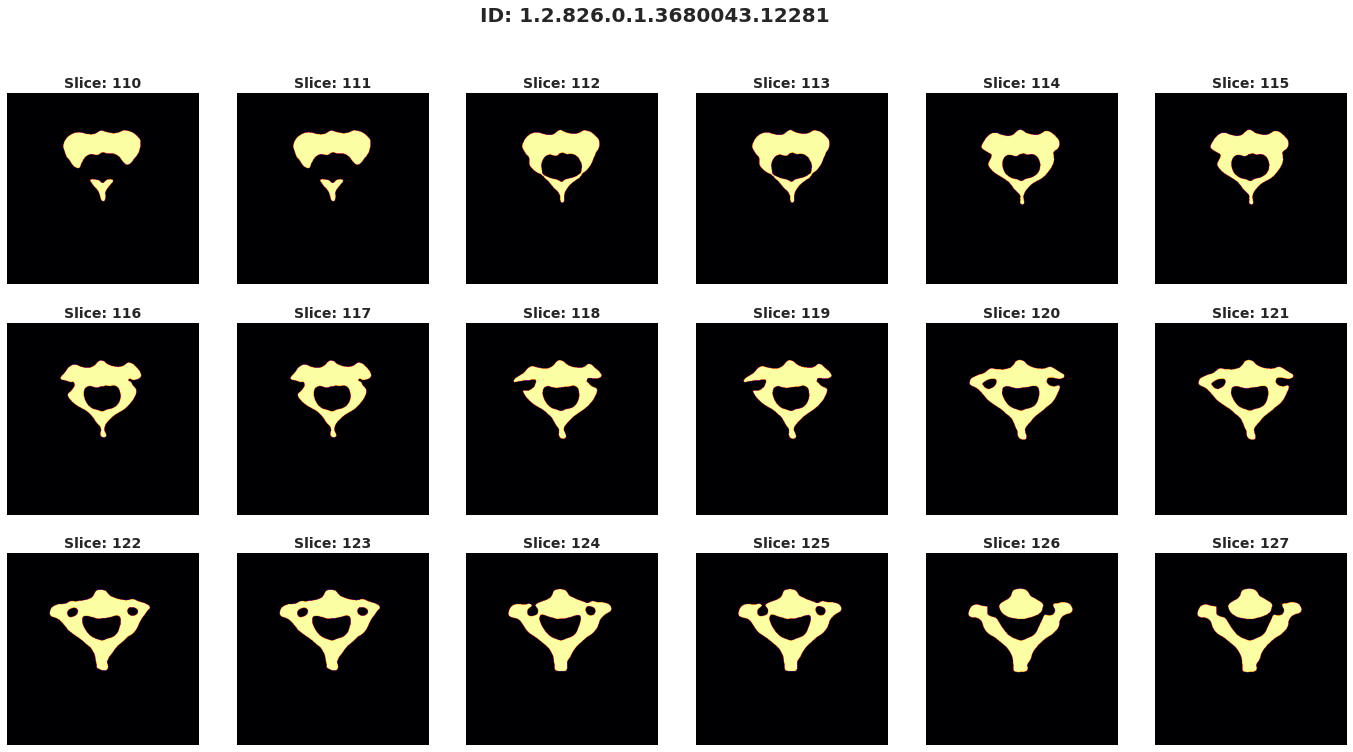

In [16]:
# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

Compare these with the previous images. These masks give us the **location** of the vertebrae, which is very helpful because we know the fractures can only occur in these regions.

They also tells us which **vertebrae** are in the images. By looking at the unique values in each slice, we find a 0 for the background and another number like 2 for vertebrae C2. 

In [17]:
np.unique(seg[116])

array([0., 2.])

Unfortunately, we don't have segmentations for the whole train set. Checkout my other [notebook](https://www.kaggle.com/code/samuelcortinhas/extracting-vertebrae-c1-c7), where I exlore how to **extract the vertebrae** for the **whole train set**.

In [18]:
# Number of cases with masks
seg_paths = glob(f"{base_path}/segmentations/*")
print(f'Number of cases with segmentations: {len(seg_paths)}, ({np.round(100*len(seg_paths)/len(train_df),1)}%)')

Number of cases with segmentations: 87, (4.3%)


An idea to keep in mind is that maybe we could train a **segmentation model** like UNet to predict the segmentation masks for the rest of the train and all of the test images. 

# 6. Extract metadata


This section uses code from Andrada Olteanu.

In [19]:
# From https://www.kaggle.com/code/andradaolteanu/rsna-fracture-detection-dicom-images-explore
def get_observation_data(path):
    '''
    Get information from the .dcm files
    '''

    dataset = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "Rows" : dataset.get("Rows"),
        "Columns" : dataset.get("Columns"),
        "SOPInstanceUID" : dataset.get("SOPInstanceUID"),
        "ContentDate" : dataset.get("ContentDate"),
        "SliceThickness" : dataset.get("SliceThickness"),
        "InstanceNumber" : dataset.get("InstanceNumber"),
        "ImagePositionPatient" : dataset.get("ImagePositionPatient"),
        "ImageOrientationPatient" : dataset.get("ImageOrientationPatient"),
    }

    # String columns
    str_columns = ["SOPInstanceUID", "ContentDate", 
                   "SliceThickness", "InstanceNumber"]
    for k in str_columns:
        observation_data[k] = str(dataset.get(k)) if k in dataset else None

    return observation_data

def get_metadata():
    '''
    Retrieves the desired metadata from the .dcm files and saves it into dataframe.
    '''
    
    exceptions = 0
    dicts = []

    for k in tqdm(range(len(train_df))):
        if (k % 100)==0:
            print(f'Iteration: {k}')
            
        dt = train_df.iloc[k, :]

        # Get all .dcm paths for this Instance
        dcm_paths = glob(f"{base_path}/train_images/{dt.StudyInstanceUID}/*")

        for path in dcm_paths:
            try:
                # Get datasets
                dataset = get_observation_data(path)
                dicts.append(dataset)
            except Exception as e:
                exceptions += 1
                continue

    # Convert into df
    meta_train_data = pd.DataFrame(data=dicts, columns=md_example.keys())
    
    # Export information
    meta_train_data.to_csv("meta_train.csv", index=False)
    
    print(f"Metadata created. Number of total fails: {exceptions}.")

In [20]:
# Example
md_example = get_observation_data(ex_path)
pprint(md_example)

{'Columns': 512,
 'ContentDate': '20220727',
 'ImageOrientationPatient': [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000],
 'ImagePositionPatient': [-52.308, -27.712, -55.218],
 'InstanceNumber': '101',
 'Rows': 512,
 'SOPInstanceUID': '1.2.826.0.1.3680043.10001.1.101',
 'SliceThickness': '0.625000'}


In [21]:
# Create and save the metadata (~ 2 hours)
#get_metadata()

You can find the dataset containing the metadata [here](https://www.kaggle.com/datasets/samuelcortinhas/rsna-2022-spine-fracture-detection-metadata). (Andrada also has a version containing only the positive patients)

In [22]:
# Read in saved metadata
meta_train = pd.read_csv("../input/rsna-2022-spine-fracture-detection-metadata/meta_train.csv")
meta_train["StudyInstanceUID"] = meta_train["SOPInstanceUID"].apply(lambda x: ".".join(x.split(".")[:-2]))
print('meta_train shape:', meta_train.shape)
meta_train.head(3)

meta_train shape: (711601, 9)


,Rows,Columns,SOPInstanceUID,ContentDate,SliceThickness,InstanceNumber,ImagePositionPatient,ImageOrientationPatient,StudyInstanceUID
0,512,512,1.2.826.0.1.3680043.6200.1.240,20220727,1.0,240,"[-118.530, -103.5302, 143.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
1,512,512,1.2.826.0.1.3680043.6200.1.12,20220727,1.0,12,"[-118.530, -103.5302, 325.70]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
2,512,512,1.2.826.0.1.3680043.6200.1.210,20220727,1.0,210,"[-118.530, -103.5302, 167.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200


**Image size**

Text(0.5, 1.02, 'Image sizes in train images')

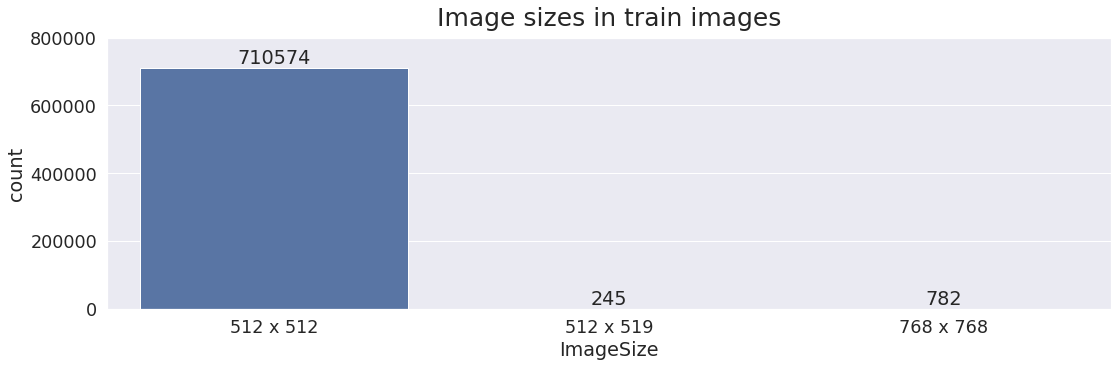

In [23]:
# Image size
meta_train["ImageSize"] = meta_train["Rows"].astype(str) + " x " + meta_train["Columns"].astype(str)

# Plot image sizes
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="ImageSize")
for container in ax.containers:
    ax.bar_label(container)
plt.ylim([0,800000])
plt.title('Image sizes in train images', fontsize=25, y=1.02)

Almost all images have size **512x512**. We should therefore **resize** the other images to size 512x512. 

**Content Date**

In [24]:
# Unique values
meta_train['ContentDate'].unique()

array([20220727])

We can drop this feature as it is constant.

In [25]:
meta_train.drop('ContentDate', axis=1, inplace=True)

**Slice Thickness**

In [26]:
meta_train["SliceThickness"].unique()

array([1.        , 0.5       , 0.625     , 0.6       , 0.67      ,
       0.9       , 0.8       , 0.488281  , 0.75      , 0.664062  ,
       0.60000002])

Text(0.5, 1.02, 'Slice thickness distribution')

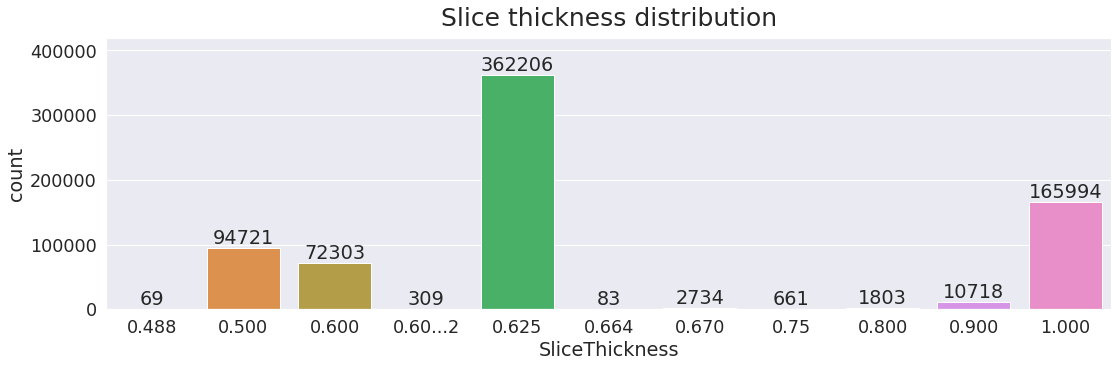

In [27]:
# Plot slice thickness
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="SliceThickness")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(['0.488','0.500','0.600','0.60...2','0.625','0.664','0.670','0.75','0.800','0.900','1.000'])
plt.ylim([0,420000])
plt.title('Slice thickness distribution', fontsize=25, y=1.02)

**Number of slices per scan**

Text(0.5, 0, 'Number of Slices')

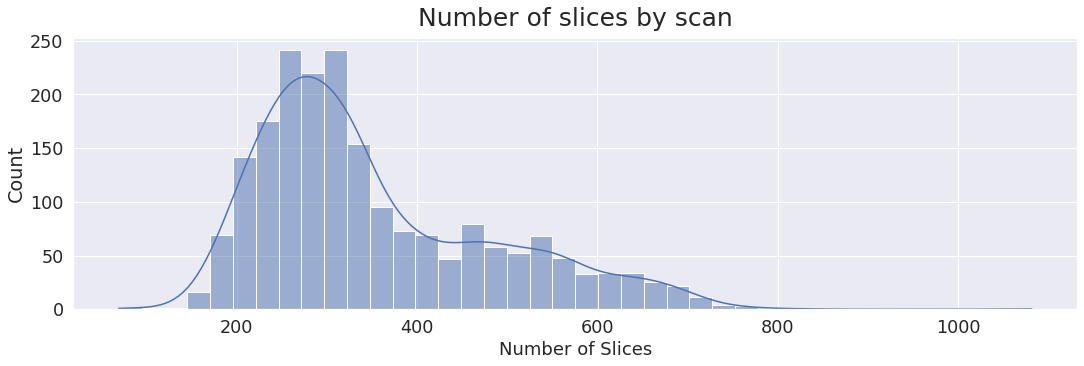

In [28]:
# Slice counts
slice_counts = meta_train["StudyInstanceUID"].value_counts().reset_index()
slice_counts.columns = ["StudyInstanceUID", "count"]

# Distribution of slices counts
plt.figure(figsize=(18, 5))
sns.histplot(data=slice_counts, x="count", kde=True, bins=40)
plt.title("Number of slices by scan", size=25, y=1.02)
plt.xlabel("Number of Slices", size = 18)

**Image Position Patient**

In [29]:
# Extract x, y, z coordinates of position vector
meta_train['ImagePositionPatient_x'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[0]))
meta_train['ImagePositionPatient_y'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[1]))
meta_train['ImagePositionPatient_z'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace(',','').replace(']','').replace('[','').split()[2]))

Text(0.5, 1.02, 'z-coordinate')

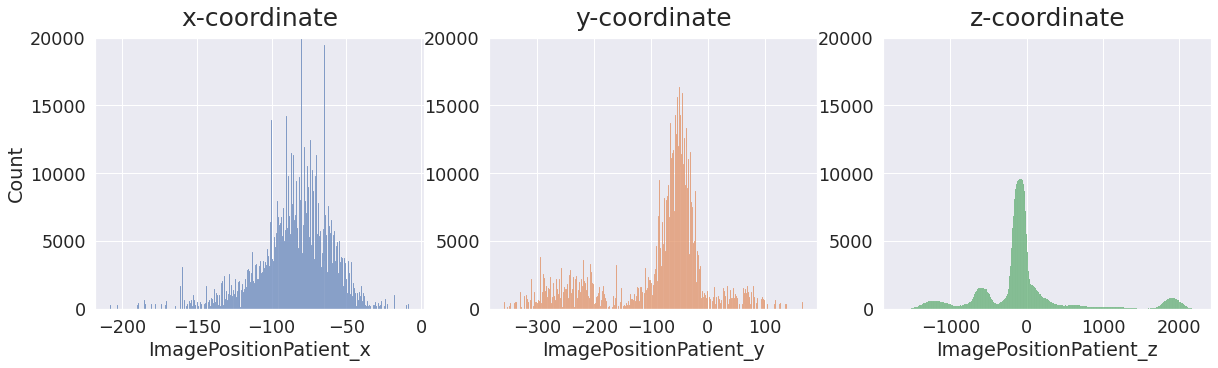

In [30]:
# Plot position coordinates
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.histplot(meta_train['ImagePositionPatient_x'])
plt.ylim([0,20000])
plt.title('x-coordinate', fontsize=25, y=1.02)

plt.subplot(1,3,2)
sns.histplot(meta_train['ImagePositionPatient_y'], color='C1')
plt.ylabel('')
plt.ylim([0,20000])
plt.title('y-coordinate', fontsize=25, y=1.02)

plt.subplot(1,3,3)
sns.histplot(meta_train['ImagePositionPatient_z'], color='C2')
plt.ylabel('')
plt.ylim([0,20000])
plt.title('z-coordinate', fontsize=25, y=1.02)

We can use the 'ImagePositionPatient_z' feature to infer the vertebrae present in each slice. It seems non-trivial though - I need to think about this.

**Image Orientation Patient**

This feature tells us coordinates for the position of the patient in the scanner. It could tell us if the images are slightly rotated for example. 

In [31]:
meta_train['ImageOrientationPatient'].nunique()

400

In [32]:
meta_train['ImageOrientationPatient'].unique()[:5]

array(['[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000]',
       '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]',
       '[1, 0, 0, 0, 1, 0]',
       '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, -0.000000]',
       '[0.997007, -2.5917e-002, 7.2833e-002, 2.2466e-002, 0.998604, 4.7813e-002]'],
      dtype=object)

**Clean meta data**

In [33]:
# Clean metadata
meta_train_clean = meta_train.drop(['SOPInstanceUID','ImagePositionPatient','ImageOrientationPatient','ImageSize'], axis=1)
meta_train_clean.rename(columns={"Rows": "ImageHeight", "Columns": "ImageWidth","InstanceNumber": "Slice"}, inplace=True)
meta_train_clean = meta_train_clean[['StudyInstanceUID','Slice','ImageHeight','ImageWidth','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']]
meta_train_clean.sort_values(by=['StudyInstanceUID','Slice'], inplace=True)
meta_train_clean.reset_index(drop=True, inplace=True)

# Export information
#meta_train_clean.to_csv("meta_train_clean.csv", index=False)

# Preview first few columns
meta_train_clean.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032


The **cleaned version** of this metadata is also in my dataset [here](https://www.kaggle.com/datasets/samuelcortinhas/rsna-2022-spine-fracture-detection-metadata).

# 7. Bounding boxes



We are only given bounding boxes for a **subset** of the data. In particular, only **12%** of patients in the train set have any bounding box measurements.

This information is useful in telling us exactly where the fractures have occured. We could consider training an **object localisation** algorithm to provide bounding boxes for the whole train set. 

In [34]:
print(f'Patients with bounding box measurements: {train_bbox["StudyInstanceUID"].nunique()} ({np.round(100*train_bbox["StudyInstanceUID"].nunique()/len(train_df),1)} %)')

Patients with bounding box measurements: 235 (11.6 %)


The bounding boxes are only provided for patients with fractures (but not all of them).

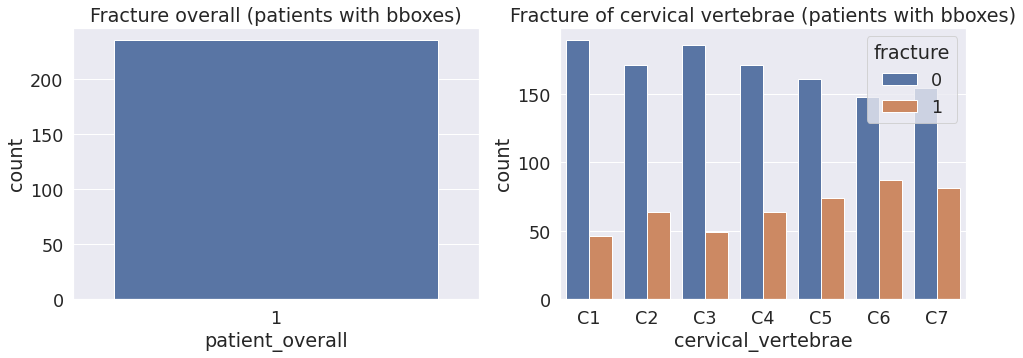

In [35]:
# From https://www.kaggle.com/code/leventelippenszky/rsna-eda-dicom-segmentations-bboxes-3d-plot
train_df_bbox = train_df[train_df["StudyInstanceUID"].isin(train_bbox["StudyInstanceUID"])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x="patient_overall", data=train_df_bbox, ax=ax1)
ax1.set_title("Fracture overall (patients with bboxes)")

train_df_bbox_melt = pd.melt(train_df_bbox, id_vars=["StudyInstanceUID", "patient_overall"], var_name="cervical_vertebrae", value_name="fracture")
sns.countplot(x="cervical_vertebrae", hue="fracture", data=train_df_bbox_melt, ax=ax2)
ax2.set_title("Fracture of cervical vertebrae (patients with bboxes)")
plt.show()

Text(0.5, 0, 'Number of bboxes')

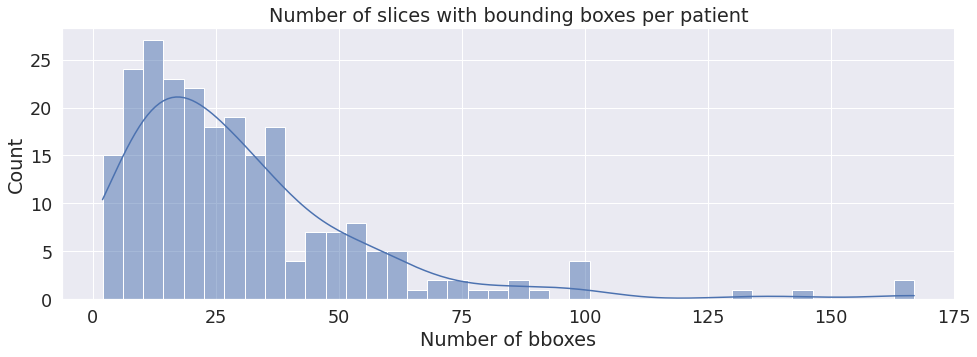

In [36]:
plt.figure(figsize=(16,5))
sns.histplot(train_bbox["StudyInstanceUID"].value_counts().values, kde=True, bins=40)
plt.title('Number of slices with bounding boxes per patient')
plt.xlabel('Number of bboxes')

Text(0.5, 1.0, 'Width and heights')

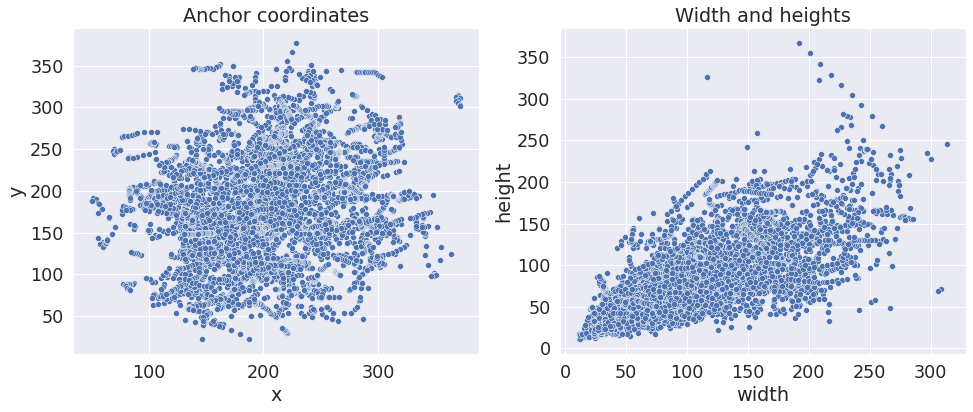

In [37]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(data=train_bbox, x='x', y='y')
plt.title('Anchor coordinates')

plt.subplot(1,2,2)
sns.scatterplot(data=train_bbox, x='width', y='height')
plt.title('Width and heights')

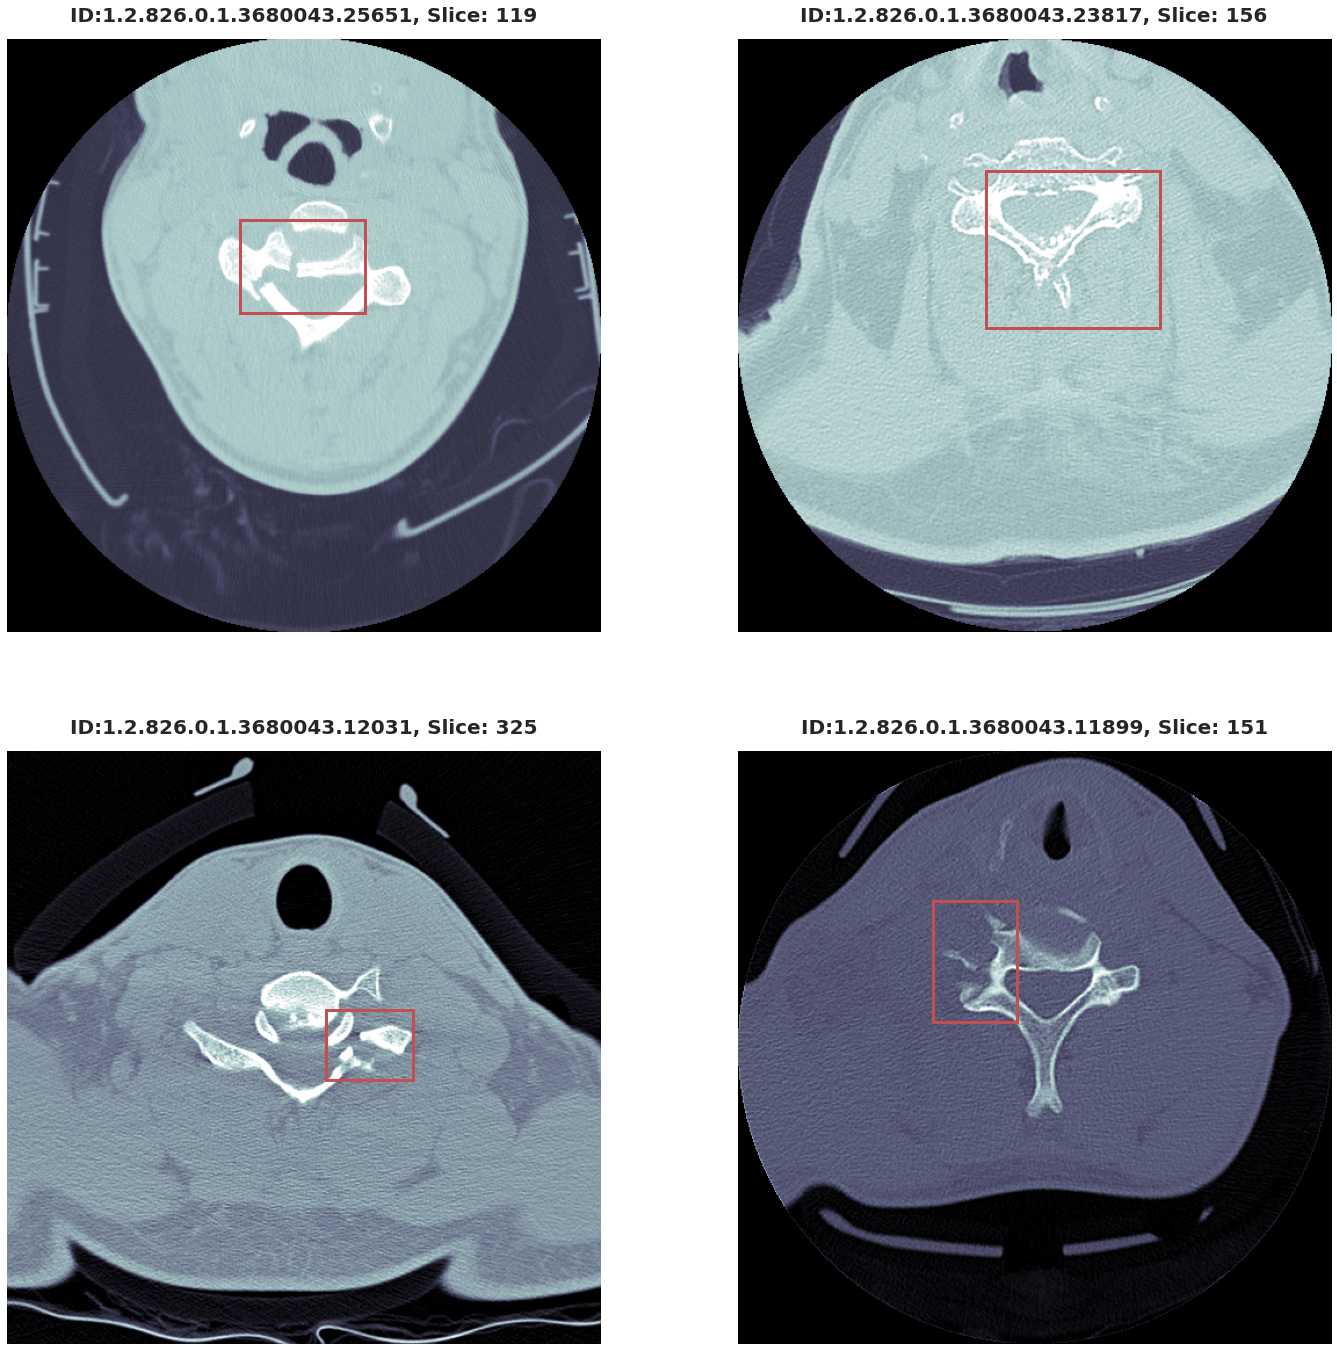

In [38]:
def plot_fracture(slice_num,bbox_id,ax_id1,ax_id2):
    file = pydicom.dcmread(f"{base_path}/train_images/{bbox_id}/{slice_num}.dcm")
    img = apply_voi_lut(file.pixel_array, file)
    info = train_bbox[(train_bbox['StudyInstanceUID']==bbox_id)&(train_bbox['slice_number']==slice_num)]
    rect = patches.Rectangle((float(info.x), float(info.y)), float(info.width), float(info.height), linewidth=3, edgecolor='r', facecolor='none')

    axes[ax_id1,ax_id2].imshow(img, cmap="bone")
    axes[ax_id1,ax_id2].add_patch(rect)
    axes[ax_id1,ax_id2].set_title(f"ID:{bbox_id}, Slice: {slice_num}", fontsize=20, weight='bold',y=1.02)
    axes[ax_id1,ax_id2].axis('off')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,24))
plot_fracture(119,'1.2.826.0.1.3680043.25651',0,0)
plot_fracture(156,'1.2.826.0.1.3680043.23817',0,1)
plot_fracture(325,'1.2.826.0.1.3680043.12031',1,0)
plot_fracture(151,'1.2.826.0.1.3680043.11899',1,1)

# 8. Baseline solution



We use the **means** but **scale them up** a bit to take into account the competition metric puts **more weight on positive cases**. (See version 14 of this notebook for a derivation of the scaling function.)

In [39]:
# Put more weight on positive predictions
def scale_up(q):
    return 2*q/(1+q)

preds = train_df.mean(numeric_only=True).map(scale_up).to_dict()
ss['fractured'] = test_df['prediction_type'].map(preds)
ss.to_csv('submission.csv', index=False)
ss.head(3)

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.134873
1,1.2.826.0.1.3680043.10454_C1,0.134873
2,1.2.826.0.1.3680043.10690_C1,0.134873
